Detailed comments and explanations will be provided later

In [ ]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install import_ipynb
!pip install moviepy
!pip install pickle5
!pip install -q mediapy
!pip install GPUtil
!pip install git+https://github.com/VLL-HD/FrEIA.git

In [ ]:
import visualize_new_code as viz
import L3net as l3
import networkx as nx
import numpy as np
import torch
import matplotlib.pyplot as plt
import Nets_new_code as nets
import utils_training_new_code as utils
import utils_data_new_code as utils_data
import importlib as ipb
import itertools
import torch_geometric as pyg
import sys
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import ipywidgets as widgets
import IPython.display as display
import mediapy as media
from FrEIA.framework import InputNode, OutputNode, Node, ReversibleGraphNet
from FrEIA.modules import GLOWCouplingBlock, PermuteRandom
import torch.nn as nn
import pandas as pd

## Loading.

In [ ]:
def get_training_input(name, version, edge_index, X_train, Y_train, X_test=None, Y_test=None):
    if name == 'real_CA_solar' or name == 'real_traffic_ATD':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        if name == 'real_CA_solar':
            edge_index_tmp = solar_loader.edge_index
            # In fact this should be unnecessary
            mean_0 = torch.Tensor([0.2485, 0.1790]).to(device)
            mean_1 = torch.Tensor([-0.7988, -0.5848]).to(device)
            mult1, mult2 = 16, 2
            data_name = f'CA_solar_{version}'
            edge_weight = torch.ones(solar_loader.edge_index.shape[1]).to(
                device)  # No edge weight
        else:
            edge_index_tmp = traffic_loader.edge_index
            mean_0 = torch.Tensor([1, -1]).to(device)
            mean_1 = torch.Tensor([-1, 1]).to(device)
            mult1, mult2 = 2, 2
            data_name = f'ATD_traffic_{version}'
            edge_weight = torch.ones(traffic_loader.edge_index.shape[1]).to(
                device)  # No edge weight
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)  # For L3net
        fix_W_g_b_g = True
        lr0 = 1e-4
        optim_classify = True
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 3, 300
    if name == 'simulation_graph':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        edge_index_tmp = torch.tensor(
            [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[
            0].to(device)  # For L3net
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        mean_0 = torch.tensor([0, 1.5]).to(device)
        mean_1 = torch.tensor([0, -1.5]).to(device)
        mult1, mult2 = 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4
        optim_classify = True
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        data_name = f'3node_graph_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 2, 100
        edge_weight = torch.tensor([1, 1, 1, 1, 1, 1, 1]).float().to(
            device)  # No edge weight
    if name == 'simulation_GP_graph':
        # Always have this L3net adj. included, but it is used only if 'L3net' is in 'version'
        edge_index_tmp = data_generator.edge_index
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[
            0].to(device)  # For L3net
        if edge_index is not None:
            use_graph = True
            edge_index = edge_index.to(device)
        else:
            use_graph = False
        mean_0 = torch.tensor([0.]).to(device)
        mean_1 = torch.tensor([-5.]).to(device)
        mult1, mult2 = 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4
        optim_classify = False
        scheduler = None
        mu, gamma = 0.1, 1
        resume_checkpoint = True
        data_name = f'GP_graph_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 2, 100
        edge_weight = torch.ones(edge_index_tmp.shape[1]).to(
            device)  # No edge weight
    if name == 'simulation_non_graph':
        edge_index = None
        A_ = None
        use_graph = False
        mean_0 = X_train[Y_train == 0].mean(axis=0).to(device)
        mean_1 = X_train[Y_train == 1].mean(axis=0).to(device)
        mult1, mult2 = 4, 4
        fix_W_g_b_g = True
        lr0 = 1e-3
        optim_classify = False
        scheduler = None
        mu, gamma = 1, 1
        resume_checkpoint = True
        data_name = f'two_moon_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        num_viz, num_to_plot = 1, 100
        edge_weight = None
    if name == 'simulation_8_gaussian':
        edge_index = None
        A_ = None
        use_graph = False
        mean_0 = X_train[Y_train == 0].mean(axis=0).to(device)
        mean_1 = X_train[Y_train == 1].mean(axis=0).to(device)
        mean_2 = X_train[Y_train == 2].mean(axis=0).to(device)
        mean_3 = X_train[Y_train == 3].mean(axis=0).to(device)
        mult1, mult2, mult3, mult4 = 1, 1, 1, 1
        fix_W_g_b_g = True
        lr0 = 5e-4
        optim_classify = False
        scheduler = None
        mu, gamma = 1, 1
        resume_checkpoint = True
        data_name = f'8_gaussian_{version}'
        X_train, Y_train = X_train.to(device), Y_train.to(device)
        X_test, Y_test = X_test.to(device), Y_test.to(device)
        num_viz, num_to_plot = 1, Ntot
        edge_weight = None
    torch.manual_seed(1103)
    model_graph = nets.InvResNet(C, output_dim, nblocks=nblocks,
                                 model_args=model_args, graph=use_graph, dim_inc=False, version=version, A_=A_).to(device)
    # Because for FC, sometimes we flatten the feature so C > 2
    gen_dim = min(2, C)
    gen_net = nets.SmallGenNet(Y_dim, gen_dim).to(
        device)  # Always flow in R^2 now
    with torch.no_grad():
        if name != 'simulation_8_gaussian':
            gen_net.fc.weight = torch.nn.Parameter(
                torch.transpose(torch.vstack([mult1*mean_0, mult2*mean_1]), 0, 1).to(device))
        else:
            gen_net.fc.weight = torch.nn.Parameter(
                torch.transpose(torch.vstack([mult1*mean_0, mult2*mean_1, mult3*mean_2, mult4*mean_3]), 0, 1).to(device))
        gen_net.fc.bias = torch.nn.Parameter(
            torch.zeros(gen_dim).to(device))
    if fix_W_g_b_g:
        for param in gen_net.parameters():
            param.requires_grad = False
    params = list(model_graph.parameters()) + list(gen_net.parameters())
    optimizer = torch.optim.Adam(params, lr=lr0, weight_decay=5e-4)
    models = [model_graph, gen_net]
    mod_args = [model_args[1], nblocks]
    train_args = [optimizer, optim_classify, mu, gamma,
                  epochs, scheduler, resume_checkpoint]
    data_args = [edge_index, edge_weight,
                 batch_size, data_name, num_viz, num_to_plot]
    return [models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test]


# A. No graph

## Two moon by iGNN

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    V, C, batch_size, epochs, F_out = 1, 2, 100, 200, 1
    output_dim, Y_dim, nblocks = 1, 2, 50
    # NOTE, the first term is the reduce factor of initial weights of model
    model_args = [0.9, 64, 3]
    N = 3000
    data_name = 'two_moon'
    X_np, y_np, X_train, Y_train = utils_data.gen_two_moon_data(N, data_name)
    X_train, Y_train = X_train.reshape(N, V, C), Y_train.reshape(N, V)

In [ ]:
for _ in ['Training_IRresNet']:
    torch.manual_seed(1103)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_non_graph', 'four_FC', edge_index, X_train, Y_train)
    data_args[-1] = 500 # Num to plot
    train_args[-1] = False
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    # simulation_trainer.all_together()

Checking generation at 
 None with 1500 out of 3000 data
Invert 600 samples took 2.4496957699998347 secs


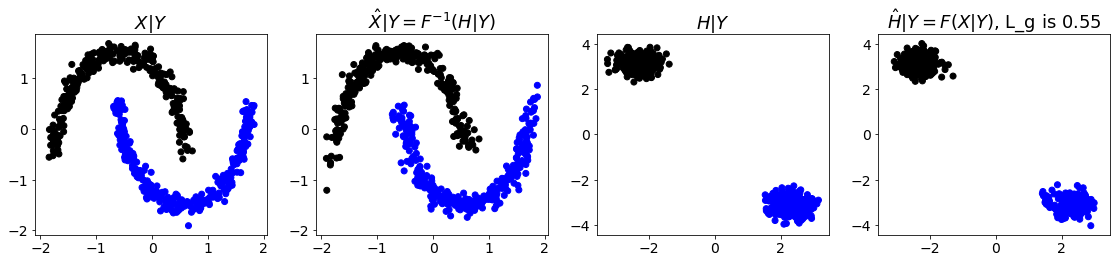

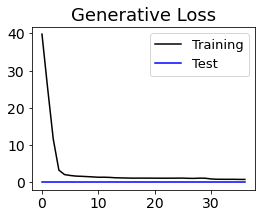

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()
    # Y_row = None
    # simulation_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(simulation_trainer)
    # simulation_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(simulation_trainer)

In [ ]:
# View images one by one, but work after refreshing
simulation_trainer.cpu_load = True
simulation_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

## 8-Gaussian

### iGNN

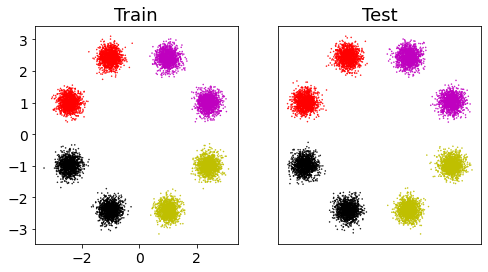

In [ ]:
for _ in ['hyper-parameters']:
    V, C, batch_size, epochs, F_out = 1, 2, 1000, 200, 1
    # Y_dim is the total number of labels Y can take (per node)
    output_dim, Y_dim, nblocks = 1, 4, 50
    # NOTE, the first term is the reduce factor of initial weights of model
    model_args = [0.9, 64, 3]
    Ntot = 1250*8 
    pos, labels = utils_data.gen_8_gaussian_data(labels='some', N=Ntot)
    pos_test, labels_test = utils_data.gen_8_gaussian_data(labels='some', N=Ntot, random_state = 1103)
    c = np.where(labels[:])[1]
    colors = np.repeat('r', len(c))
    colors[c==1] = 'm'
    colors[c==2] = 'y'
    colors[c==3] = 'k'
    c = np.where(labels_test[:])[1]
    colors_test = np.repeat('r', len(c))
    colors_test[c==1] = 'm'
    colors_test[c==2] = 'y'
    colors_test[c==3] = 'k'
    X_train = pos.reshape(Ntot, 1, 2)
    Y_train = torch.where(labels == 1)[1].reshape(Ntot, 1)
    X_test = pos_test.reshape(Ntot, 1, 2)
    Y_test = torch.where(labels_test == 1)[1].reshape(Ntot, 1)
    fig, ax = plt.subplots(1,2,figsize=(8,4))
    ax[0].scatter(pos[:, 0], pos[:, 1], c=colors, s=0.25)
    ax[0].set_title('Train')
    ax[1].scatter(pos_test[:, 0], pos_test[:, 1], c=colors_test, s=0.25)
    ax[1].set_title('Test')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
for _ in ['Training_IRresNet']:
    torch.manual_seed(1103)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_8_gaussian', 'four_FC', edge_index, X_train, Y_train, X_test, Y_test)
    train_args[-1] = False 
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.stop_criterion = 1e-6
    simulation_trainer.epochs = 174 # Pause after 174 epochs
    simulation_trainer.all_together()

Checking generation at 
 None with 2500 out of 10000 data
Invert 1000 samples took 0.5745999320006376 secs


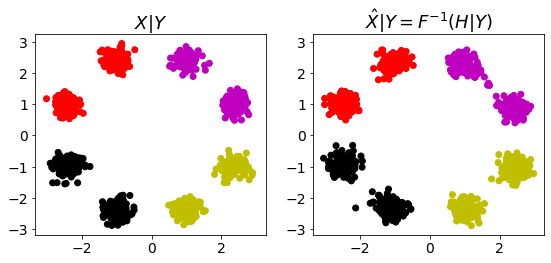

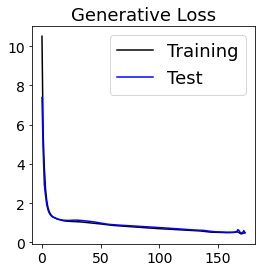

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()

### CINN-MMD or CINN-Nflow

In [ ]:
for _ in ['hyper-parameters']:
    V, C, batch_size, epochs, F_out = 1, 2, 1000, 200, 1
    # Y_dim is the total number of labels Y can take (per node)
    output_dim, Y_dim, nblocks = 1, 4, 50
    # NOTE, the first term is the reduce factor of initial weights of model
    model_args = [0.9, 64, 3]
    Ntot = 1250*8
    pos, labels = utils_data.gen_8_gaussian_data(labels='some', N=Ntot)
    pos_test, labels_test = utils_data.gen_8_gaussian_data(
        labels='some', N=Ntot, random_state=1103)
    c = np.where(labels[:])[1]
    colors = np.repeat('r', len(c))
    colors[c == 1] = 'm'
    colors[c == 2] = 'y'
    colors[c == 3] = 'k'
    c = np.where(labels_test[:])[1]
    colors_test = np.repeat('r', len(c))
    colors_test[c == 1] = 'm'
    colors_test[c == 2] = 'y'
    colors_test[c == 3] = 'k'
    X_train = pos.reshape(Ntot, 1, 2)
    Y_train = torch.where(labels == 1)[1].reshape(Ntot, 1)
    X_test = pos_test.reshape(Ntot, 1, 2)
    Y_test = torch.where(labels_test == 1)[1].reshape(Ntot, 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(pos[:, 0], pos[:, 1], c=colors, s=0.25)
    ax[0].set_title('Train')
    ax[1].scatter(pos_test[:, 0], pos_test[:, 1], c=colors_test, s=0.25)
    ax[1].set_title('Test')
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
for _ in ['Training_CINN']:
    torch.manual_seed(1103)
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_8_gaussian', 'four_FC', edge_index, X_train, Y_train, X_test, Y_test)
    # for CINN_obj in ['', '_Nflow']:
    for CINN_obj in ['_Nflow']:
        ########## CINN here ##########
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 50, 0.1, 5e-4
        else:
            dim, nblocks, clamp_val, lr = 512, 5, 2.0, 1e-3
        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, dim), nn.ReLU(),
                                nn.Linear(dim,  c_out))
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        ########## CINN end ##########
        train_args[-1] = True
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.stop_criterion = 1e-7
        simulation_trainer.epochs = 200
        simulation_trainer.CINN_obj = CINN_obj
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.all_together_competitor()

Checking generation at 
 None with 10000 out of 10000 data


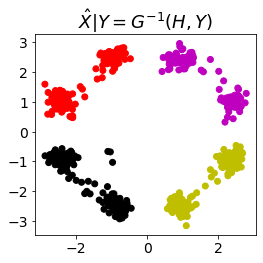

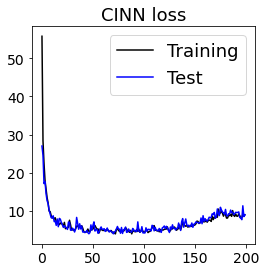

########################################################
Checking generation at 
 None with 10000 out of 10000 data


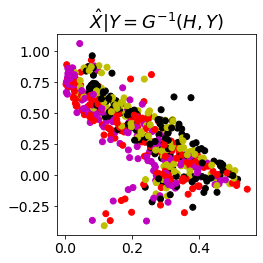

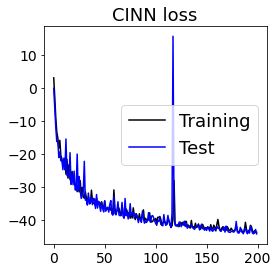

########################################################


In [ ]:
for _ in ['Load_and_visualize']:
    for CINN_obj in ['', '_Nflow']:
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 50, 0.1, 5e-4
        else:
            dim, nblocks, clamp_val, lr = 512, 5, 2.0, 1e-3
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj  # Nflow or '', which denotes MMD
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.resume_checkpoint = True
        simulation_trainer.final_viz = True
        simulation_trainer.cpu_load = True
        simulation_trainer.load_from_checkpoint_competitors()
        simulation_trainer.viz_generation_competitors()
        simulation_trainer.viz_losses_competitors()
        print('########################################################')

### CGAN

In [ ]:
for _ in ['CGAN']:
    # NOTE: model expressiveness can be an issue (e.g., H->X cannot distinguish between two nodes)
    version = 'four_FC'
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_8_gaussian', version, edge_index, X_train, Y_train, X_test, Y_test)
    ########## CGAN HERE ##########
    dim = 64
    A_, graph = None, False
    nblocks = 20  # Note, stacking too many is very bad
    net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                          version=version, A_=A_).to(device)
    nblocks = 40  # Note, stacking too many is very bad
    net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False,
                          graph, version=version, A_=A_).to(device)
    optimizer_D = torch.optim.Adam(
        net_D.parameters(), lr=1e-4, weight_decay=0.5)
    optimizer_G = torch.optim.Adam(
        net_G.parameters(), lr=5e-4, weight_decay=0.5)
    models[0] = [net_D, net_G]
    train_args[0] = [optimizer_D, optimizer_G]
    ########## CGAN END ##########
    train_args[-1] = False  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.all_together_competitor()

Checking generation at 
 None with 10000 out of 10000 data


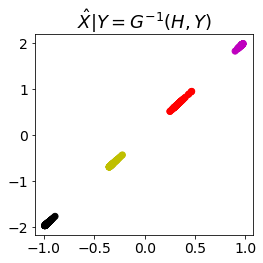

In [ ]:
for _ in ['Load_and_visualize']:
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.resume_checkpoint = True
    simulation_trainer.final_viz = True
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint_competitors()
    simulation_trainer.viz_generation_competitors()

### Two-sample testing

In [ ]:
overleaf_path = ''
types = ['8_gaussian']
viz_train = False  # True or False. On IID data, just once on test is enough
full_res_dict = {}
for type in types:
    V, C, batch_size, epochs, F_out = 1, 2, 1000, 200, 1
    # Y_dim is the total number of labels Y can take (per node)
    output_dim, Y_dim, nblocks = 1, 4, 50
    model_args = [0.9, 64, 3]
    Ntot = 1250*8
    pos, labels = utils_data.gen_8_gaussian_data(labels='some', N=Ntot)
    pos_test, labels_test = utils_data.gen_8_gaussian_data(
        labels='some', N=Ntot, random_state=1103)
    c = np.where(labels[:])[1]
    colors = np.repeat('r', len(c))
    colors[c == 1] = 'm'
    colors[c == 2] = 'y'
    colors[c == 3] = 'k'
    c = np.where(labels_test[:])[1]
    colors_test = np.repeat('r', len(c))
    colors_test[c == 1] = 'm'
    colors_test[c == 2] = 'y'
    colors_test[c == 3] = 'k'
    X_train = pos.reshape(Ntot, 1, 2)
    Y_train = torch.where(labels == 1)[1].reshape(Ntot, 1)
    X_test = pos_test.reshape(Ntot, 1, 2)
    Y_test = torch.where(labels_test == 1)[1].reshape(Ntot, 1)
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    ax[0].scatter(pos[:, 0], pos[:, 1], c=colors, s=0.25)
    ax[0].set_title('Train')
    ax[1].scatter(pos_test[:, 0], pos_test[:, 1], c=colors_test, s=0.25)
    ax[1].set_title('Test')
    plt.xticks([])
    plt.yticks([])
    plt.show()
    # Model
    prefices = ['FC', 'CINN', 'CINN_Nflow', 'CGAN']
    two_sample_stat_dict = {}
    for prefix in prefices:
        CINN_obj = prefix[4:]
        gen_mtd = prefix
        prefix = overleaf_path+type+'_'+prefix+'_'
        if 'FC' in prefix:
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_8_gaussian', 'four_FC', edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'CGAN' in prefix:
            # NOTE: model expressiveness can be an issue (e.g., H->X cannot distinguish between two nodes)
            version = 'four_FC'
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_8_gaussian', version, edge_index, X_train, Y_train, X_test, Y_test)
            ########## CGAN HERE ##########
            dim = 64
            A_, graph = None, False
            nblocks = 20  # Note, stacking too many is very bad
            net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                                  version=version, A_=A_).to(device)
            nblocks = 40  # Note, stacking too many is very bad
            net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False,
                                  graph, version=version, A_=A_).to(device)
            optimizer_D = torch.optim.Adam(
                net_D.parameters(), lr=1e-4, weight_decay=0.5)
            optimizer_G = torch.optim.Adam(
                net_G.parameters(), lr=5e-4, weight_decay=0.5)
            models[0] = [net_D, net_G]
            train_args[0] = [optimizer_D, optimizer_G]
            ########## CGAN END ##########
            train_args[-1] = False  # If resume_training
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'CINN' in prefix:
            torch.manual_seed(1103)
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_8_gaussian', 'four_FC', edge_index, X_train, Y_train, X_test, Y_test)
            # for CINN_obj in ['', '_Nflow']:
            ########## CINN here ##########
            if 'Nflow' in CINN_obj:
                dim, nblocks, clamp_val, lr = 64, 50, 0.1, 5e-4
            else:
                dim, nblocks, clamp_val, lr = 512, 5, 2.0, 1e-3

            def subnet_fc(c_in, c_out):
                return nn.Sequential(nn.Linear(c_in, dim), nn.ReLU(),
                                     nn.Linear(dim,  c_out))
            nodes = [InputNode(ndim_tot, name='input')]
            for k in range(nblocks):
                nodes.append(Node(nodes[-1],
                                  GLOWCouplingBlock,
                                  {'subnet_constructor': subnet_fc,
                                      'clamp': clamp_val},
                                  name=F'coupling_{k}'))
                nodes.append(Node(nodes[-1],
                                  PermuteRandom,
                                  {'seed': k},
                                  name=F'permute_{k}'))
            ndim_x = V*C
            ndim_y = V*Y_dim
            ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
            nodes.append(OutputNode(nodes[-1], name='output'))
            model = ReversibleGraphNet(nodes, verbose=False).to(device)
            l2_reg = 2e-5
            optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                         eps=1e-6, weight_decay=l2_reg)
            models[0] = [model]
            train_args[0] = optimizer
            ########## CINN end ##########
            train_args[-1] = False
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            simulation_trainer.stop_criterion = 1e-6
            simulation_trainer.CINN_obj = CINN_obj
            simulation_trainer.data_name += simulation_trainer.CINN_obj
            simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        # Visualization
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        train_args[-1] = True  # If resume_training
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.prefix = prefix
        simulation_trainer.cpu_load = True
        if 'CGAN' in prefix or 'CINN' in prefix:
            simulation_trainer.load_from_checkpoint_competitors()
            simulation_trainer.final_viz = True
            simulation_trainer.viz_generation_competitors(viz_train=viz_train)
            simulation_trainer.viz_losses_competitors()
        else:
            simulation_trainer.load_from_checkpoint()  # Load previous models from file
            simulation_trainer.get_H_cond_Y()  # Get H|Y
            simulation_trainer.viz = True  # If report transport cost
            simulation_trainer.final_viz = True
            simulation_trainer.viz_generation(viz_train=viz_train)
            simulation_trainer.viz_losses()
        if gen_mtd == 'CINN':
            gen_mtd = 'CINN: MMD'
        if gen_mtd == 'CINN_Nflow':
            gen_mtd = 'CINN: Nflow'
        if gen_mtd in ['L3', 'Cheb', 'FC']:
            gen_mtd = f'Ours: {gen_mtd}'
        two_sample_stat_dict[gen_mtd] = simulation_trainer.two_sample_stat
    full_res_dict[type] = utils.get_stat_frame_from_dict(
        two_sample_stat_dict)
    suff = '_test' if viz_train == False else ''
    torch.save(full_res_dict, f'8gaussian_metrics{suff}')

In [ ]:
viz_train = False
suff = '_test' if viz_train == False else ''
full_res_dict = torch.load(f'8gaussian_metrics{suff}')

In [ ]:
three_node_res = full_res_dict['8_gaussian']
three_node_res[0]

MMD: alpha=0.1  MMD: alpha=1.0  MMD: alpha=5.0  MMD: alpha=10.0  \
Ours: FC              0.001           0.002           0.004            0.003   
CINN: MMD             0.000           0.002           0.004            0.004   
CINN: Nflow           0.367           0.947           0.620            0.460   
CGAN                  0.148           0.299           0.273            0.266   

             Energy  
Ours: FC      0.004  
CINN: MMD     0.004  
CINN: Nflow   1.582  
CGAN          0.601

In [ ]:
three_node_res[1]

gen_method                      Ours: FC  CINN: MMD  CINN: Nflow   CGAN
Ys             two_sample                                              
None 10000 obs MMD: alpha=0.1      0.001      0.000        0.367  0.148
               MMD: alpha=1.0      0.002      0.002        0.947  0.299
               MMD: alpha=5.0      0.004      0.004        0.620  0.273
               MMD: alpha=10.0     0.003      0.004        0.460  0.266
               Energy              0.004      0.004        1.582  0.601

# B. Graph: 3 node convex/non-convex features

## B.1 Convex feature

### iGNN

In [ ]:
# NOTE: try a FC net by treating the graph as a vector
# Data
num_sample_per_class = 4000
data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
# data_generator.small_averaging = True
# data_generator.complex_X = True
# data_generator.disporportional = True
# data_generator.P_square = True
# data_generator.plot_X_Z = True
data_generator.get_full_data()
Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))
data_generator.select_Y(Y_rows)
X_train, Y_train = data_generator.X_full, data_generator.Y_full
data_generator.get_full_data()
data_generator.select_Y(Y_rows)
X_test, Y_test = data_generator.X_full, data_generator.Y_full
# Model
V, C = 3, 2
edge_index = None # Need to be None, because we now have L3net under Sequential module (will be improved later)
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'simulation_graph', 'one_L3_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
train_args[-1] = True  # If resume_training
num_viz = len(Y_rows)
data_args[2] = int(1000/(8/num_viz))  # Num batch
data_args[3] = '3node_graph_one_L3_two_FC'
data_args[-2] = num_viz  # Only visualize Y that are used
simulation_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
# simulation_trainer.all_together()

Checking generation at 
 tensor([1., 1., 1.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9530671289999191 secs


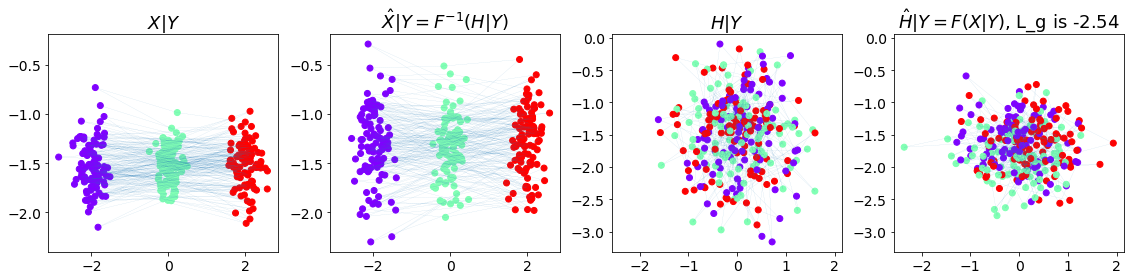

Checking generation at 
 tensor([1., 1., 0.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9429242430001068 secs


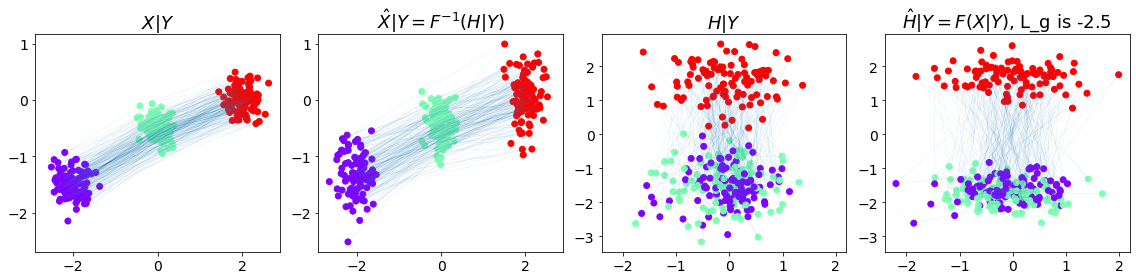

Checking generation at 
 tensor([1., 0., 0.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9590835489998426 secs


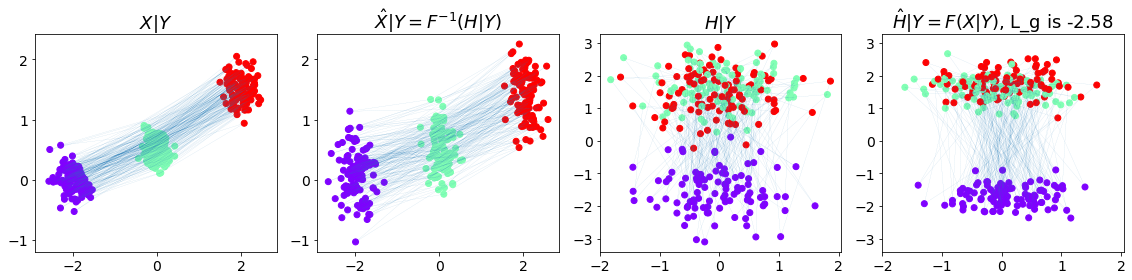

Checking generation at 
 tensor([1., 0., 1.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9726582910000161 secs


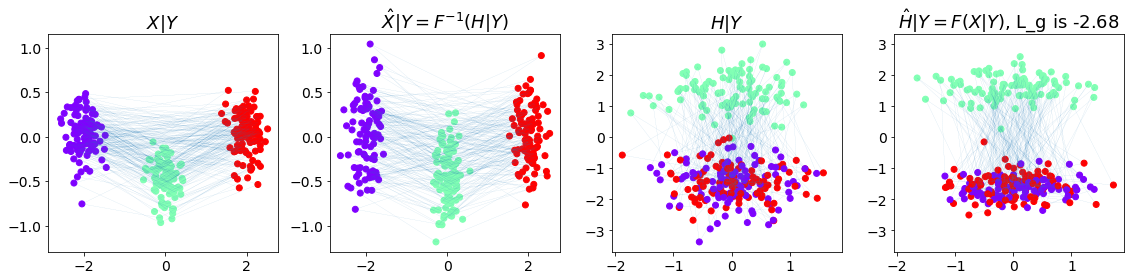

Checking generation at 
 tensor([0., 0., 1.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9779811949999839 secs


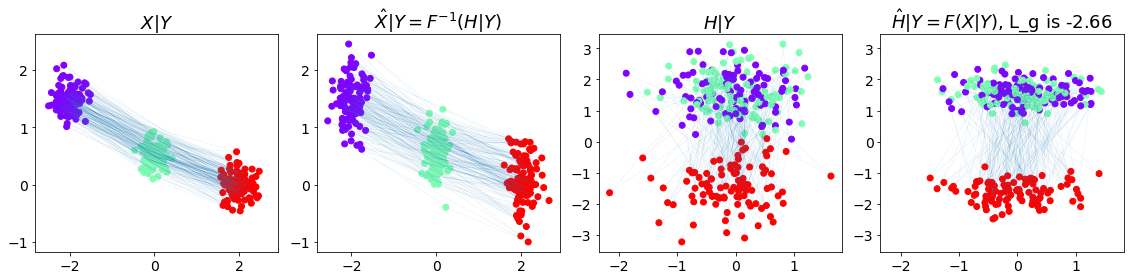

Checking generation at 
 tensor([0., 0., 0.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9578933000000234 secs


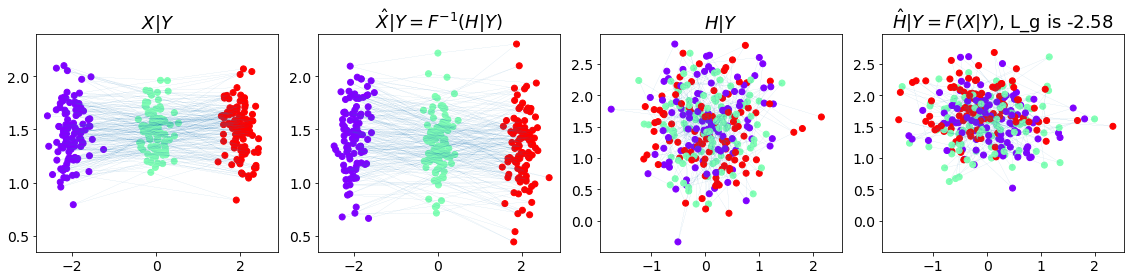

Checking generation at 
 tensor([0., 1., 0.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9431523440000547 secs


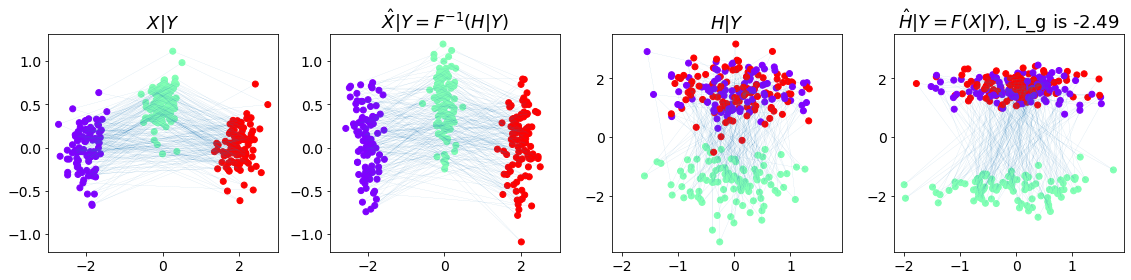

Checking generation at 
 tensor([0., 1., 1.], device='cuda:0') with 4000 out of 32000 data
Invert 100 samples took 0.9436389869999857 secs


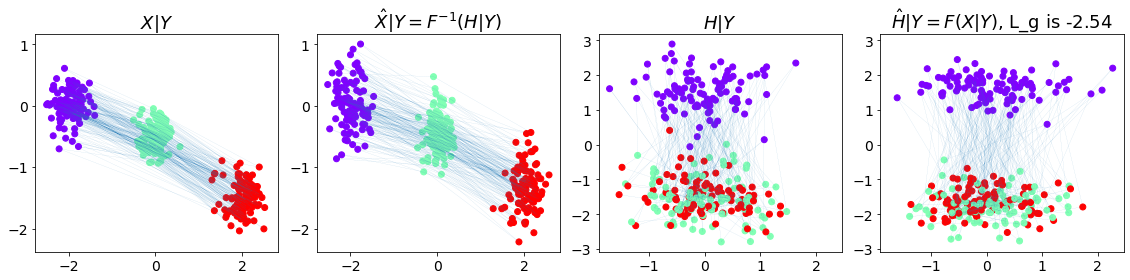

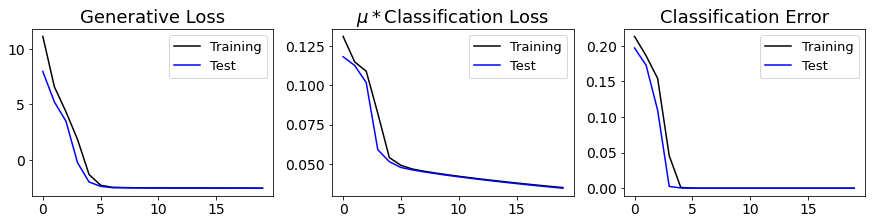

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     simulation_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[-2]
    # print(f'Flow gif at {Y_row}')
    # simulation_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(simulation_trainer)
    # simulation_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(simulation_trainer)

In [ ]:
# View images one by one, but work after refreshing
simulation_trainer.cpu_load = True
simulation_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
Unique_Y, counts_Y = torch.unique(
    simulation_trainer.Y_train, return_counts=True, dim=0)
counts_Y, idx = torch.sort(counts_Y, descending=True)
Y_rows = Unique_Y[idx]
Y_row = Y_rows[-2]
print(f'Flow Train gif at {Y_row}')
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

### CINN-MMD or CINN-Nflow

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    # Y_rows = torch.tensor([[0, 0, 0]])
    Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
for _ in ['Training_CINN']:
   # Data
    num_sample_per_class = 4000
    data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_train, Y_train = data_generator.X_full, data_generator.Y_full
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_test, Y_test = data_generator.X_full, data_generator.Y_full
    # Model
    V, C = 3, 2
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_graph', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
    # for CINN_obj in ['', '_Nflow']:
    for CINN_obj in ['_Nflow']:
        ########## CINN here ##########
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
        else:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                nn.Linear(dim,  c_out))
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        ########## CINN end ##########
        train_args[-1] = False
        num_viz = len(Y_rows)
        data_args[2] = int(1000/(8/num_viz))  # Num batch
        data_args[-2] = num_viz  # Only visualize Y that are used
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.all_together_competitor()

In [ ]:
for _ in ['Load_and_visualize']:
    epoch_ls = []
    for CINN_obj in ['', '_Nflow']:
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj  # Nflow or '', which denotes MMD
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.resume_checkpoint = True
        simulation_trainer.final_viz = True
        simulation_trainer.cpu_load = True
        simulation_trainer.load_from_checkpoint_competitors()
        epoch = simulation_trainer.epoch + 1
        epoch_ls.append(epoch)
        simulation_trainer.viz_generation_competitors()
        simulation_trainer.viz_losses_competitors()
        print('########################################################')


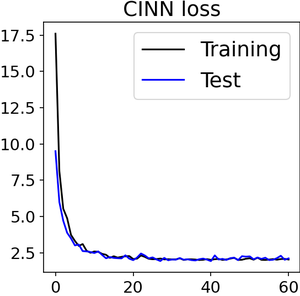


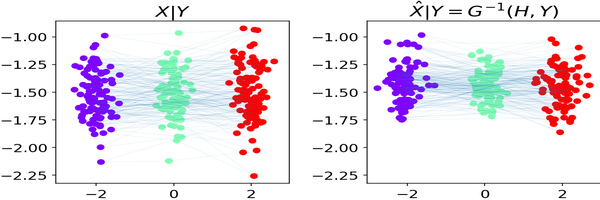
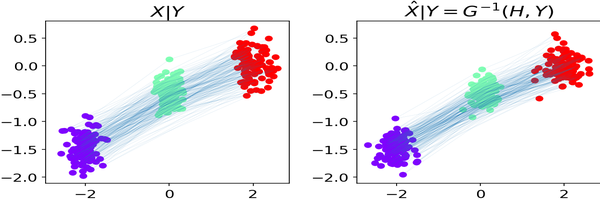
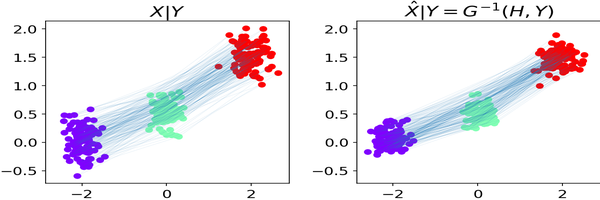
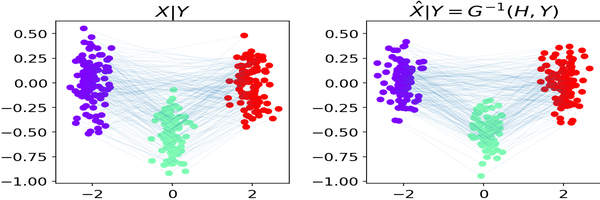
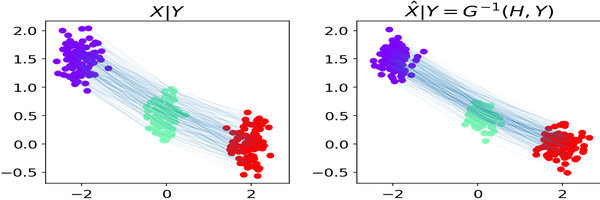
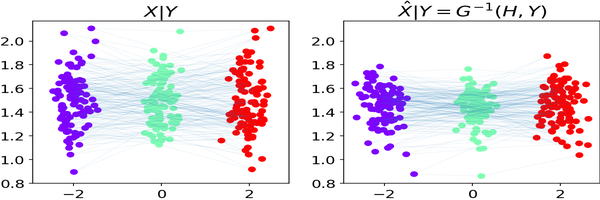
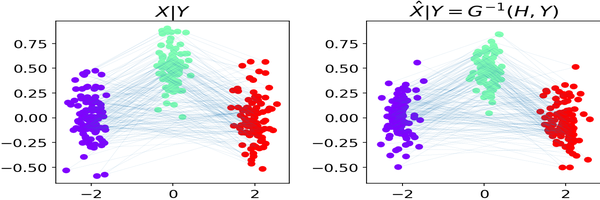
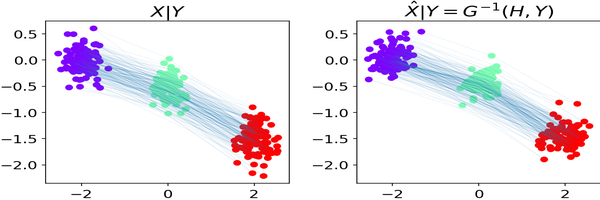

########################################################



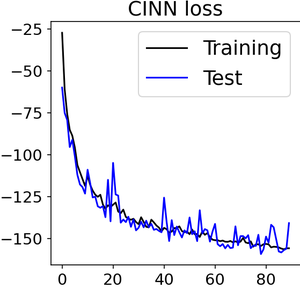


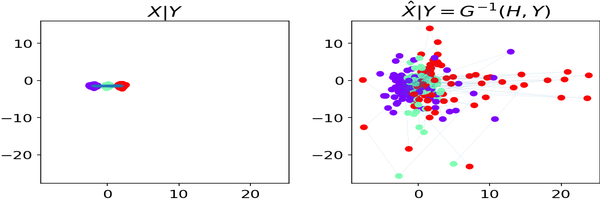
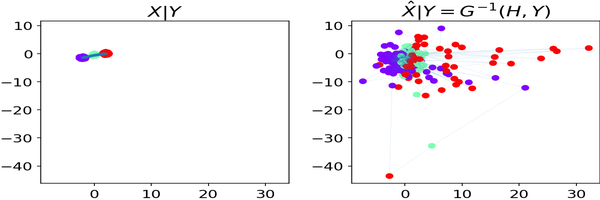
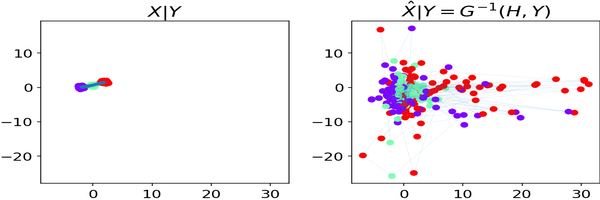
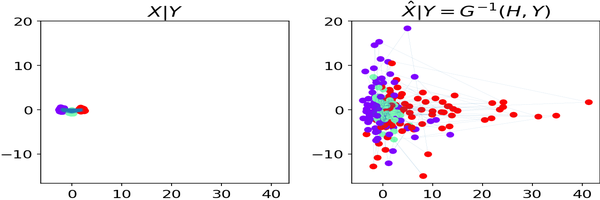
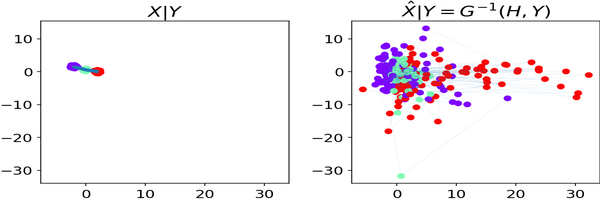
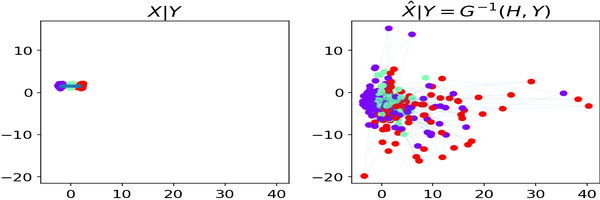
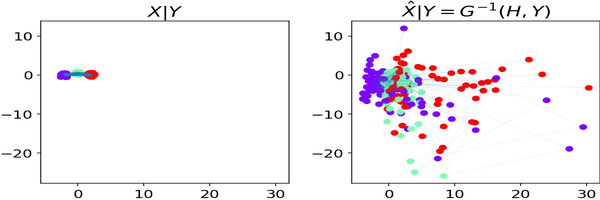
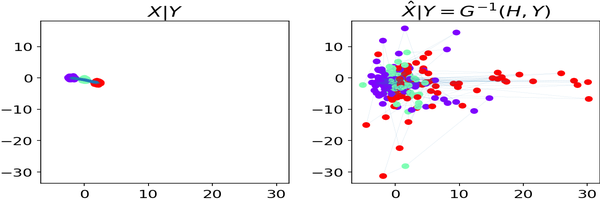

########################################################


In [ ]:
# View images one by one, but work after refreshing
Num = range(1,9)
for i, CINN_obj in enumerate(['', '_Nflow']):
    epoch = epoch_ls[i]
    version, method = 'three_FC', 'CINN'
    media.show_image(media.read_image(f'3node_graph_{version}{CINN_obj}_{method}/Losses_epoch{epoch}.png'),width=300)
    loss_images = {f'At Y={Y_rows[i-1].numpy()}': media.read_image(f'3node_graph_{version}{CINN_obj}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
    media.show_images(loss_images,height=200,width=600, columns = 2)
    print('########################################################')

### CGAN 


In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    # Y_rows = torch.tensor([[0, 0, 0]])
    Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
for _ in ['CGAN']:
    # NOTE: model expressiveness can be an issue (e.g., H->X cannot distinguish between two nodes)
    # Data
    num_sample_per_class = 4000
    data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_train, Y_train = data_generator.X_full, data_generator.Y_full
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_test, Y_test = data_generator.X_full, data_generator.Y_full
    # Model
    V, C = 3, 2
    version = 'one_L3_two_FC'
    edge_index = torch.tensor([[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
    if 'L3' in version or 'Cheb' not in version:
        edge_index = None
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_graph', version, edge_index, X_train, Y_train, X_test, Y_test)
    ########## CGAN HERE ##########
    dim = 64
    edge_index_tmp = torch.tensor(
        [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
    A_, graph = None, True
    if 'L3' in version or 'Cheb' not in version:
        A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)
        graph = False
    nblocks = 20 # Note, stacking too many is very bad
    net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                          version=version, A_=A_).to(device)
    nblocks = 40 # Note, stacking too many is very bad
    net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False, graph, version=version, A_=A_).to(device)
    optimizer_D = torch.optim.Adam(net_D.parameters(), lr=1e-4, weight_decay = 0.5)
    optimizer_G = torch.optim.Adam(net_G.parameters(), lr=5e-4, weight_decay = 0.5)
    models[0] = [net_D, net_G]
    train_args[0] = [optimizer_D, optimizer_G]
    ########## CGAN END ##########
    train_args[-1] = True  # If resume_training
    train_args[-3] = 500  # Num epochs
    num_viz = len(Y_rows)
    data_args[2] = int(1000/(8/num_viz))  # Num batch
    # data_args[3] = '3node_graph_one_Cheb_two_FC_small_ave_fix_Y'
    data_args[-2] = num_viz  # Only visualize Y that are used
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.stop_criterion = 1e-6
    simulation_trainer.all_together_competitor()

In [ ]:
simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
simulation_trainer.resume_checkpoint = True
simulation_trainer.load_from_checkpoint_competitors()
simulation_trainer.final_viz = True
epoch = simulation_trainer.epoch + 1
simulation_trainer.viz_generation_competitors()
simulation_trainer.viz_losses_competitors()
# simulation_trainer.viz_generation_competitors(viz_train=False)


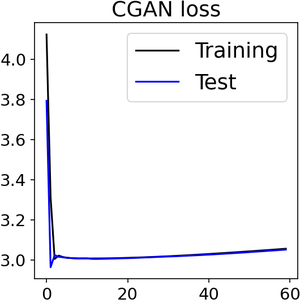


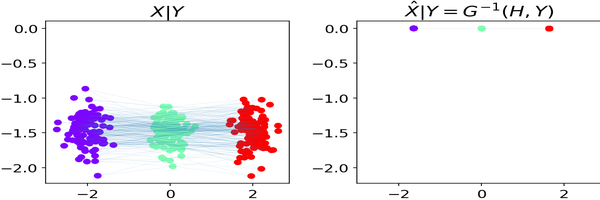
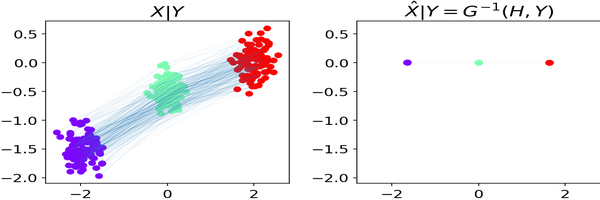
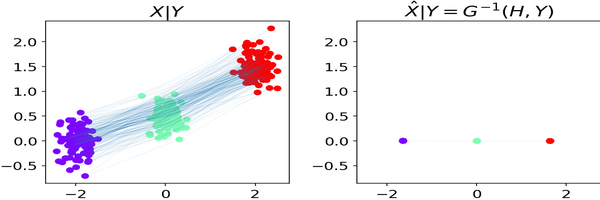
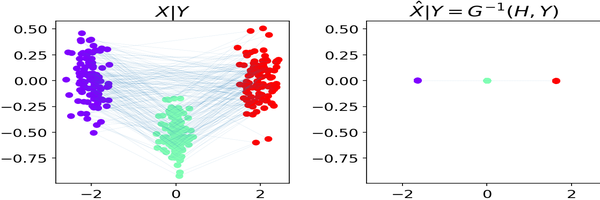
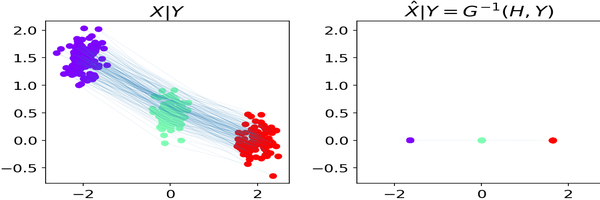
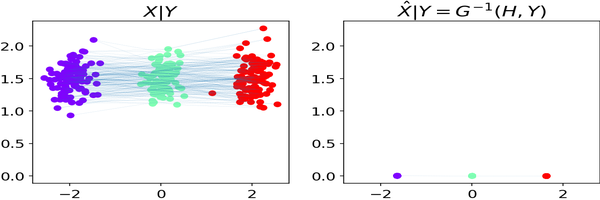
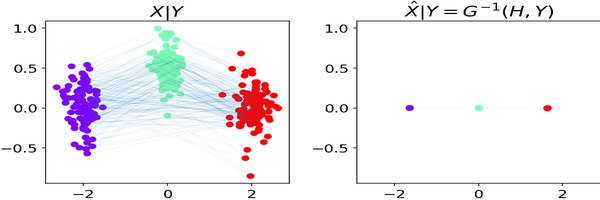
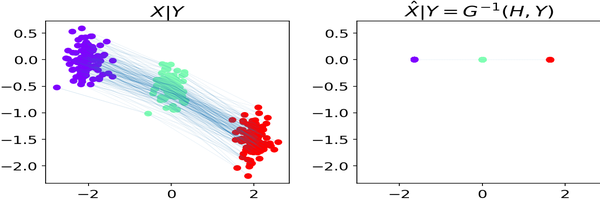

In [ ]:
# View images one by one, but work after refreshing
Num = range(1,9)
version, method = 'one_L3_two_FC', 'CGAN'
media.show_image(media.read_image(f'3node_graph_{version}_{method}/Losses_epoch{epoch}.png'),width=300)
loss_images = {f'At Y={Y_rows[i-1].numpy()}': media.read_image(f'3node_graph_{version}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
media.show_images(loss_images,height=200,width=600, columns = 2)

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    # Y_rows = torch.tensor([[0, 0, 0]])
    Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
gr = nx.Graph()
gr.add_edges_from([(0,1),(1,0),(2,1),(1,2),(0,0),(1,1),(2,2)])
nx.draw(gr, with_labels=True, node_color='white')

## B.2 Non-convex feature


In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    Y_rows = torch.tensor([[0, 0, 0], [1, 0, 0]])
    # Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
gr = nx.Graph()
gr.add_edges_from([(0,1),(1,0),(2,1),(1,2),(0,0),(1,1),(2,2)])
nx.draw(gr, with_labels=True, node_color='white')

### iGNN


In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    Y_rows = torch.tensor([[0, 0, 0], [1, 0, 0]])
    # Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
for _ in ['Training_IRresNet_GNN']:
    # NOTE: model expressiveness can be an issue (e.g., H->X cannot distinguish between two nodes)
    # Data
    num_sample_per_class = 4000
    data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
    # data_generator.small_averaging = True
    data_generator.complex_X = True
    # data_generator.disporportional = True
    # data_generator.P_square = True 
    # data_generator.plot_X_Z = True
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_train, Y_train = data_generator.X_full, data_generator.Y_full
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_test, Y_test = data_generator.X_full, data_generator.Y_full
    # Model
    V, C = 3, 2
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_graph', 'one_L3_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
    train_args[-1] = True  # If resume_training
    num_viz = len(Y_rows)
    data_args[2] = int(1000/(8/num_viz))  # Num batch
    data_args[3] = '3node_graph_one_L3_two_FC_fix_Y_complex_X'
    data_args[-2] = num_viz  # Only visualize Y that are used
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    # simulation_trainer.all_together()

Checking generation at 
 tensor([1., 0., 0.], device='cuda:0') with 4000 out of 8000 data
Invert 100 samples took 1.624190351000152 secs


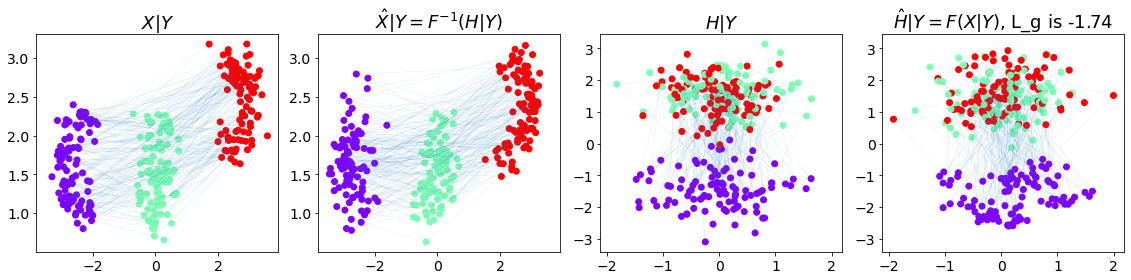

Checking generation at 
 tensor([0., 0., 0.], device='cuda:0') with 4000 out of 8000 data
Invert 100 samples took 1.5763657420000072 secs


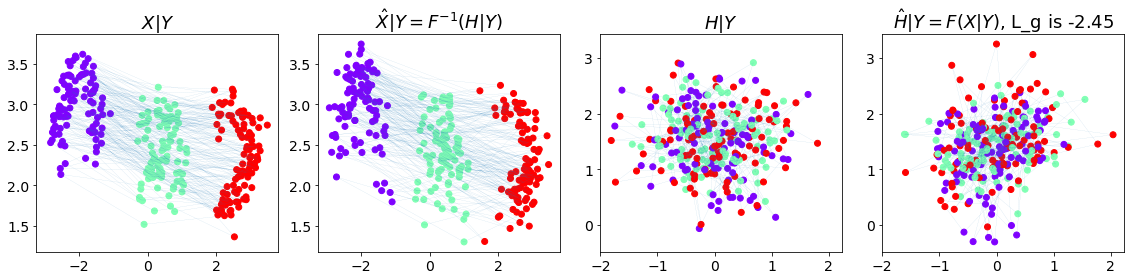

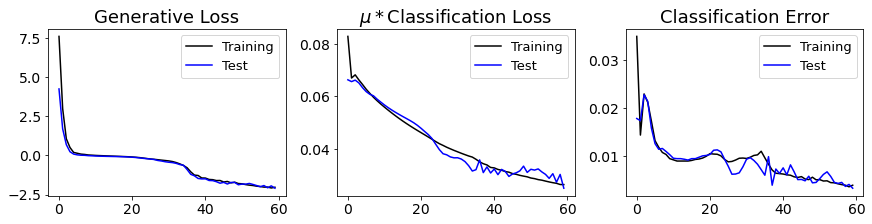

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()
    # Unique_Y, counts_Y = torch.unique(
    #     simulation_trainer.Y_train, return_counts=True, dim=0)
    # counts_Y, idx = torch.sort(counts_Y, descending=True)
    # Y_rows = Unique_Y[idx]
    # Y_row = Y_rows[-2]
    # print(f'Flow gif at {Y_row}')
    # simulation_trainer.get_GIF(Y_row)
    # viz.trajectory_to_gif(simulation_trainer)
    # simulation_trainer.get_GIF(Y_row, from_X_to_H=True)
    # viz.trajectory_to_gif(simulation_trainer)

In [ ]:
# View images one by one, but work after refreshing
simulation_trainer.cpu_load = True
simulation_trainer.load_from_checkpoint()  # Load previous models from file
fileXtoH = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_XtoH.mp4'
fileHtoX = f'{simulation_trainer.path}/trajectory_epoch{simulation_trainer.epoch}_HtoX.mp4'
print(fileXtoH)
print(fileHtoX)
Unique_Y, counts_Y = torch.unique(
    simulation_trainer.Y_train, return_counts=True, dim=0)
counts_Y, idx = torch.sort(counts_Y, descending=True)
Y_rows = Unique_Y[idx]
Y_row = Y_rows
print(f'Flow Train gif at {Y_row}')
flows = {'Flow_XtoH': media.read_video(fileXtoH), 'Flow_HtoX': media.read_video(fileHtoX)}
media.show_videos(flows, width = 400, height = 650)

### CINN-MMD

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    Y_rows = torch.tensor([[0, 0, 0], [1, 0, 0]])
    # Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))

In [ ]:
for _ in ['Training_CINN']:
   # Data
    num_sample_per_class = 4000
    data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
    data_generator.complex_X = True
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_train, Y_train = data_generator.X_full, data_generator.Y_full
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_test, Y_test = data_generator.X_full, data_generator.Y_full
    # Model
    V, C = 3, 2
    edge_index = None
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
        'simulation_graph', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
    for CINN_obj in ['']:
        ########## CINN here ##########
        if 'Nflow' in CINN_obj:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
        else:
            dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
        def subnet_fc(c_in, c_out):
            return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                nn.Linear(dim,  c_out))
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        nodes = [InputNode(ndim_tot, name='input')]
        for k in range(nblocks):
            nodes.append(Node(nodes[-1],
                              GLOWCouplingBlock,
                              {'subnet_constructor': subnet_fc, 'clamp': clamp_val},
                              name=F'coupling_{k}'))
            nodes.append(Node(nodes[-1],
                              PermuteRandom,
                              {'seed': k},
                              name=F'permute_{k}'))
        nodes.append(OutputNode(nodes[-1], name='output'))
        model = ReversibleGraphNet(nodes, verbose=False).to(device)
        l2_reg = 2e-5
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.8, 0.9),
                                    eps=1e-6, weight_decay=l2_reg)
        models[0] = [model]
        train_args[0] = optimizer
        ########## CINN end ##########
        train_args[-1] = False
        num_viz = len(Y_rows)
        data_args[2] = int(1000/(8/num_viz))  # Num batch
        data_args[-2] = num_viz  # Only visualize Y that are used
        data_args[3] += '_fix_Y_complex'
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        # simulation_trainer.all_together_competitor()

In [ ]:
for _ in ['Load_and_visualize']:
    for CINN_obj in ['']:
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj  # Nflow or '', which denotes MMD
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.resume_checkpoint = True
        simulation_trainer.final_viz = True
        simulation_trainer.cpu_load = True
        simulation_trainer.load_from_checkpoint_competitors()
        epoch = simulation_trainer.epoch + 1
        simulation_trainer.viz_generation_competitors()
        print('########################################################')


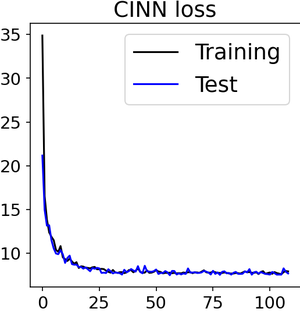


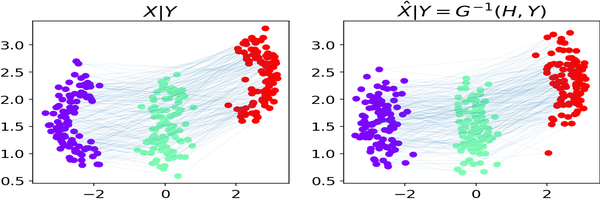
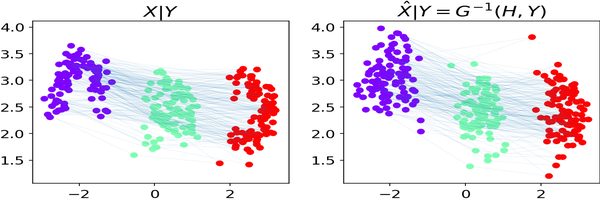

In [ ]:
# View images one by one, but work after refreshing
Num = range(1,3)
version, method = 'three_FC_fix_Y_complex', 'CINN'
media.show_image(media.read_image(f'3node_graph_{version}_{method}/Losses_epoch{epoch}.png'),width=300)
loss_images = {f'At Y={Y_rows[i-1].numpy()}': media.read_image(f'3node_graph_{version}_{method}/Generation_train_epoch{epoch}_top{i}_occurrences.png') for i in Num}
media.show_images(loss_images,height=200,width=600, columns = 2)

## B.3 Two-sample testing

In [ ]:
types = ['3node', '3node_complex']
# types = ['3node_complex']
# types = ['3node']
overleaf_path = ''
viz_train = False  # True or False. On IID data, just once on test is enough
full_res_dict = {}
for type in types:
    batch_size, epochs, F_out = 2000, 500, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    model_args = [0.9, 64, 3]
    # Y_rows = torch.tensor([[0, 0, 0]])
    Y_rows = torch.tensor(list(itertools.product(*[[0, 1], [0, 1], [0, 1]])))
    if 'complex' in type:
        Y_rows = torch.tensor([[0, 0, 0], [1, 0, 0]])
    num_sample_per_class = 4000
    data_generator = utils_data.graph_simulate_3node(num_sample_per_class)
    # data_generator.small_averaging = True
    if 'complex' in type:
        data_generator.complex_X = True
    # data_generator.disporportional = True
    # data_generator.P_square = True
    # data_generator.plot_X_Z = True
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_train, Y_train = data_generator.X_full, data_generator.Y_full
    data_generator.get_full_data()
    data_generator.select_Y(Y_rows)
    X_test, Y_test = data_generator.X_full, data_generator.Y_full
    # Model
    save_table = True # Default True
    prefices = ['L3', 'Cheb',  'CINN', 'CINN_Nflow', 'CGAN', 'FC']
    # prefices = ['Cheb', 'FC']
    two_sample_stat_dict = {}
    for prefix in prefices:
        if 'complex' in type and prefix not in ['L3', 'CINN']:
            continue
        CINN_obj = prefix[4:]
        gen_mtd = prefix
        prefix = overleaf_path+type+'_'+prefix+'_'
        if 'L3' in prefix:
            V, C = 3, 2
            # Need to be None, because we now have L3net under Sequential module (will be improved later)
            edge_index = None
            version = 'one_L3_three_FC' if 'complex' in type else 'one_L3_two_FC'
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_graph', version, edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False  # If resume_training
            num_viz = len(Y_rows)
            data_args[2] = int(1000/(8/num_viz))  # Num batch
            data_args[3] = f'3node_graph_{version}'
            if 'complex' in type:
                data_args[3] += '_fix_Y_complex'
            data_args[-2] = num_viz  # Only visualize Y that are used
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'Cheb' in prefix:
            V, C = 3, 2
            edge_index = torch.tensor(
                [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_graph', 'one_Cheb_two_FC', edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False  # If resume_training
            num_viz = len(Y_rows)
            data_args[2] = int(1000/(8/num_viz))  # Num batch
            data_args[3] = '3node_graph_one_Cheb_two_FC'
            data_args[-2] = num_viz  # Only visualize Y that are used
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'FC' in prefix:
            V, C = 1, 6
            N = X_train.shape[0]
            X_train = X_train.reshape(N, V, C)
            X_test = X_test.reshape(N, V, C)
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_graph', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
            train_args[-1] = False  # If resume_training
            num_viz = len(Y_rows)
            data_args[2] = int(1000/(8/num_viz))  # Num batch
            data_args[3] = '3node_graph_three_FC'
            data_args[-2] = num_viz  # Only visualize Y that are used
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'CGAN' in prefix:
            V, C = 3, 2
            version = 'one_L3_two_FC'
            edge_index = torch.tensor(
                [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
            if 'L3' in version or 'Cheb' not in version:
                edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_graph', version, edge_index, X_train, Y_train, X_test, Y_test)
            ########## CGAN HERE ##########
            dim = 64
            edge_index_tmp = torch.tensor(
                [[0, 1, 1, 2, 0, 1, 2], [1, 0, 2, 1, 0, 1, 2]])
            A_, graph = None, True
            if 'L3' in version or 'Cheb' not in version:
                A_ = pyg.utils.to_dense_adj(edge_index_tmp)[0].to(device)
                graph = False
            nblocks = 20  # Note, stacking too many is very bad
            net_D = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, True, graph,
                                  version=version, A_=A_).to(device)
            nblocks = 40  # Note, stacking too many is very bad
            net_G = nets.CGAN_net(C+Y_dim, dim, Y_dim, nblocks, False,
                                  graph, version=version, A_=A_).to(device)
            optimizer_D = torch.optim.Adam(
                net_D.parameters(), lr=1e-4, weight_decay=0.5)
            optimizer_G = torch.optim.Adam(
                net_G.parameters(), lr=5e-4, weight_decay=0.5)
            models[0] = [net_D, net_G]
            train_args[0] = [optimizer_D, optimizer_G]
            ########## CGAN END ##########
            train_args[-1] = False  # If resume_training
            train_args[-3] = 500  # Num epochs
            num_viz = len(Y_rows)
            data_args[2] = int(1000/(8/num_viz))  # Num batch
            # data_args[3] = '3node_graph_one_Cheb_two_FC_small_ave_fix_Y'
            data_args[-2] = num_viz  # Only visualize Y that are used
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        if 'CINN' in prefix:
            V, C = 3, 2
            edge_index = None
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
                'simulation_graph', 'three_FC', edge_index, X_train, Y_train, X_test, Y_test)
            ########## CINN here ##########
            if 'Nflow' in CINN_obj:
                dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
            else:
                dim, nblocks, clamp_val, lr = 64, 40, 0.25, 5e-4
            # model = nets.stacked_NVP(d=V*C, c=V*Y_dim, hidden=dim,
            #                          num_b=nblocks, version='four_FC').to(device)

            def subnet_fc(c_in, c_out):
                return nn.Sequential(nn.Linear(c_in, dim), nn.ELU(), nn.Linear(dim,  dim), nn.ELU(),
                                     nn.Linear(dim,  c_out))
            ndim_x = V*C
            ndim_y = V*Y_dim
            ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
            nodes = [InputNode(ndim_tot, name='input')]
            for k in range(nblocks):
                nodes.append(Node(nodes[-1],
                                  GLOWCouplingBlock,
                                  # Was 2.0 when dim == 512 and nblocks = 5
                                  {'subnet_constructor': subnet_fc,
                                      'clamp': clamp_val},
                                  name=F'coupling_{k}'))
                nodes.append(Node(nodes[-1],
                                  PermuteRandom,
                                  {'seed': k},
                                  name=F'permute_{k}'))
            nodes.append(OutputNode(nodes[-1], name='output'))
            model = ReversibleGraphNet(nodes, verbose=False).to(device)
            l2_reg = 2e-5
            optimizer = torch.optim.Adam(
                model.parameters(), lr=lr, weight_decay=l2_reg)
            models[0] = [model]
            train_args[0] = optimizer
            ########## CINN end ##########
            train_args[-1] = False  # If resume_training
            train_args[-3] = 500  # Num epochs
            num_viz = len(Y_rows)
            data_args[2] = int(1000/(8/num_viz))  # Num batch
            data_args[-2] = num_viz  # Only visualize Y that are used
            if 'complex' in type:
                data_args[3] += '_fix_Y_complex'
            simulation_trainer = utils.IResNet_training_on_graph(
                models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
            simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        # Visualization
        ndim_x = V*C
        ndim_y = V*Y_dim
        ndim_tot = ndim_x+ndim_y+V*4  # 4 dimension per node for padding
        train_args[-1] = True  # If resume_training
        simulation_trainer = utils.IResNet_training_on_graph(
            models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
        simulation_trainer.CINN_obj = CINN_obj
        simulation_trainer.data_name += simulation_trainer.CINN_obj
        simulation_trainer.ndim_x, simulation_trainer.ndim_y, simulation_trainer.ndim_tot = ndim_x, ndim_y, ndim_tot
        simulation_trainer.prefix = prefix
        simulation_trainer.cpu_load = True
        if 'CGAN' in prefix or 'CINN' in prefix:
            simulation_trainer.load_from_checkpoint_competitors()
            simulation_trainer.final_viz = True
            simulation_trainer.viz_generation_competitors(viz_train=viz_train)
            simulation_trainer.viz_losses_competitors()
        else:
            simulation_trainer.load_from_checkpoint()  # Load previous models from file
            simulation_trainer.get_H_cond_Y()  # Get H|Y
            simulation_trainer.viz = True  # If report transport cost
            simulation_trainer.final_viz = True
            simulation_trainer.viz_generation(viz_train=viz_train)
            simulation_trainer.viz_losses()
        if gen_mtd == 'CINN':
            gen_mtd = 'CINN: MMD'
        if gen_mtd == 'CINN_Nflow':
            gen_mtd = 'CINN: Nflow'
        if gen_mtd in ['L3', 'Cheb', 'FC']:
            gen_mtd = f'Ours: {gen_mtd}'
        two_sample_stat_dict[gen_mtd] = simulation_trainer.two_sample_stat
    full_res_dict[type] = utils.get_stat_frame_from_dict(
        two_sample_stat_dict)
if save_table and len(full_res_dict) > 1:
    # Both datasets included
    suff = '_test' if viz_train == False else ''
    torch.save(full_res_dict, f'3node_metrics{suff}')

In [ ]:
viz_train = False
suff = '_test' if viz_train == False else ''
full_res_dict = torch.load(f'3node_metrics{suff}')

In [ ]:
three_node_res = full_res_dict['3node']
three_node_res[0]

MMD: alpha=0.1  MMD: alpha=1.0  MMD: alpha=5.0  MMD: alpha=10.0  \
Ours: L3              0.007           0.053           0.049            0.027   
Ours: Cheb            0.455           0.324           0.109            0.047   
CGAN                  0.499           1.325           1.181            1.084   
CINN: MMD             0.003           0.021           0.032            0.024   
CINN: Nflow           0.749           0.628           0.205            0.087   
Ours: FC              0.005           0.044           0.043            0.025   

             Energy  
Ours: L3      0.062  
Ours: Cheb    2.519  
CGAN          2.813  
CINN: MMD     0.028  
CINN: Nflow   5.570  
Ours: FC      0.049

In [ ]:
three_node_res[1]

gen_method                                     Ours: L3  Ours: Cheb   CGAN  \
Ys                            two_sample                                     
tensor([1., 1., 1.]) 4000 obs MMD: alpha=0.1      0.019       0.469  0.964   
                              MMD: alpha=1.0      0.009       0.484  0.471   
                              MMD: alpha=5.0      0.005       0.479  0.468   
                              MMD: alpha=10.0     0.003       0.445  0.097   
                              Energy              0.003       0.448  0.465   
tensor([1., 1., 0.]) 4000 obs MMD: alpha=0.1      0.009       0.461  0.966   
                              MMD: alpha=1.0      0.002       0.441  0.098   
                              MMD: alpha=5.0      0.009       0.417  0.466   
                              MMD: alpha=10.0     0.089       0.330  1.625   
                              Energy              0.058       0.343  1.501   
tensor([1., 0., 0.]) 4000 obs MMD: alpha=0.1      0.050       0.340  1.503   
                              MMD: alpha=1.0      0.040       0.311  0.666   
                              MMD: alpha=5.0      0.037       0.321  1.501   
                              MMD: alpha=10.0     0.053       0.333  1.629   
                              Energy              0.037       0.314  0.669   
tensor([1., 0., 1.]) 4000 obs MMD: alpha=0.1      0.063       0.300  1.503   
                              MMD: alpha=1.0      0.061       0.109  1.202   
                              MMD: alpha=5.0      0.051       0.115  1.203   
                              MMD: alpha=10.0     0.051       0.114  1.207   
                              Energy              0.042       0.102  1.106   
tensor([0., 0., 1.]) 4000 obs MMD: alpha=0.1      0.041       0.108  1.206   
                              MMD: alpha=1.0      0.046       0.113  1.204   
                              MMD: alpha=5.0      0.042       0.106  1.109   
                              MMD: alpha=10.0     0.056       0.103  1.208   
                              Energy              0.031       0.047  1.085   
tensor([0., 0., 0.]) 4000 obs MMD: alpha=0.1      0.028       0.050  1.087   
                              MMD: alpha=1.0      0.029       0.049  1.088   
                              MMD: alpha=5.0      0.024       0.044  1.075   
                              MMD: alpha=10.0     0.023       0.047  1.088   
                              Energy              0.025       0.049  1.087   
tensor([0., 1., 0.]) 4000 obs MMD: alpha=0.1      0.025       0.046  1.076   
                              MMD: alpha=1.0      0.031       0.045  1.089   
                              MMD: alpha=5.0      0.122       2.595  4.656   
                              MMD: alpha=10.0     0.069       2.680  2.782   
                              Energy              0.054       2.657  2.775   
tensor([0., 1., 1.]) 4000 obs MMD: alpha=0.1      0.040       2.456  1.045   
                              MMD: alpha=1.0      0.036       2.471  2.763   
                              MMD: alpha=5.0      0.066       2.550  4.665   
                              MMD: alpha=10.0     0.035       2.441  1.048   
                              Energy              0.075       2.302  2.769   

gen_method                                     CINN: MMD  CINN: Nflow  \
Ys                            two_sample                                
tensor([1., 1., 1.]) 4000 obs MMD: alpha=0.1       0.005        0.623   
                              MMD: alpha=1.0       0.002        0.635   
                              MMD: alpha=5.0       0.002        0.820   
                              MMD: alpha=10.0      0.002        0.740   
                              Energy               0.003        0.793   
tensor([1., 1., 0.]) 4000 obs MMD: alpha=0.1       0.004        0.914   
                              MMD: alpha=1.0       0.003        0.787   
                              MMD: alpha=5.0       0.004        0.

But the performance on non-convex cases are clearly better by ours.

In [ ]:
three_node_complex_res = full_res_dict['3node_complex']
three_node_complex_res[0]

MMD: alpha=0.1  MMD: alpha=1.0  MMD: alpha=5.0  MMD: alpha=10.0  \
Ours: L3            0.001           0.006           0.005            0.003   
CINN: MMD           0.003           0.012           0.011            0.007   

           Energy  
Ours: L3    0.008  
CINN: MMD   0.020

In [ ]:
three_node_complex_res[1]

gen_method                                     Ours: L3  CINN: MMD
Ys                            two_sample                          
tensor([1., 0., 0.]) 4000 obs MMD: alpha=0.1      0.002      0.004
                              MMD: alpha=1.0      0.000      0.003
                              MMD: alpha=5.0      0.008      0.014
                              MMD: alpha=10.0     0.003      0.009
                              Energy              0.008      0.013
tensor([0., 0., 0.]) 4000 obs MMD: alpha=0.1      0.003      0.010
                              MMD: alpha=1.0      0.004      0.007
                              MMD: alpha=5.0      0.002      0.006
                              MMD: alpha=10.0     0.012      0.023
                              Energy              0.004      0.017

# C. Model expressiveness

## C.1 $\Sigma = g(A)$

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 400, 50, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    # it is 0.01 b/c we flow in R^1 continuously and scale too large cause non-invertibility. It is 1 because we just flow continuous in R
    model_args = [0.01, 1, 3]

Corr matrix: tensor([[ 1.0000,  0.0098, -0.2854,  0.0769,  0.0769, -0.2854,  0.0098],
        [ 0.0098,  1.0000,  0.2272, -0.1292, -0.1292, -0.1331, -0.5216],
        [-0.2854,  0.2272,  1.0000, -0.1054, -0.1054, -0.4219, -0.1331],
        [ 0.0769, -0.1292, -0.1054,  1.0000, -0.4216, -0.1054, -0.1292],
        [ 0.0769, -0.1292, -0.1054, -0.4216,  1.0000, -0.1054, -0.1292],
        [-0.2854, -0.1331, -0.4219, -0.1054, -0.1054,  1.0000,  0.2272],
        [ 0.0098, -0.5216, -0.1331, -0.1292, -0.1292,  0.2272,  1.0000]],
       device='cuda:0', grad_fn=<MmBackward0>)
Correlation Dist. are [-0.5199999809265137, -0.41999998688697815, -0.28999999165534973, -0.12999999523162842, -0.10999999940395355, 0.23000000417232513, 1.0], 
 with frequency [2, 4, 4, 12, 8, 4, 7]


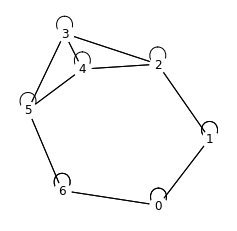

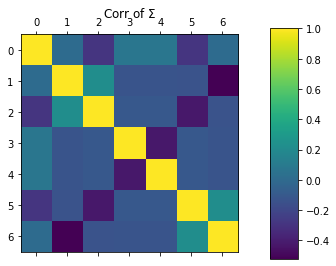

In [ ]:
num_sample = 4000
Sigma_type = 'ChebNet'  # 'ChebNet' or 'Local'
V = 7 if Sigma_type == 'ChebNet' else 3
data_generator = utils_data.GP_graph(num_sample, V)
data_generator.gen_1d_GP_data(Sigma_type=Sigma_type)

### iGNN

In [ ]:
# Data
num_sample = 4000
Sigma_type = 'ChebNet'  # 'ChebNet' or 'Local'
V = 7 if Sigma_type == 'ChebNet' else 3
data_generator = utils_data.GP_graph(num_sample, V)
data_generator.gen_1d_GP_data(Sigma_type=Sigma_type)
# Below for training, was a part of the whole things
X_train, Y_train = data_generator.X_train, data_generator.Y_train
X_test, Y_test = data_generator.X_test, data_generator.Y_test
# Model
C = 1
edge_index = data_generator.edge_index
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'simulation_GP_graph', 'one_Cheb', edge_index, X_train, Y_train, X_test, Y_test)
train_args[-1] = False  # If resume_training
data_args[-2] = 1  # Only visualize Y that are used
if 'one_Cheb' in data_args[-3]:
    # Include edge weight for Cheb
    data_args[1] = data_generator.edge_weights
simulation_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
# simulation_trainer.all_together()

Checking generation at 
 tensor([0., 0., 0., 0., 0., 0., 0.], device='cuda:0') with 4000 out of 4000 data
Invert 100 samples took 1.6791305179995106 secs


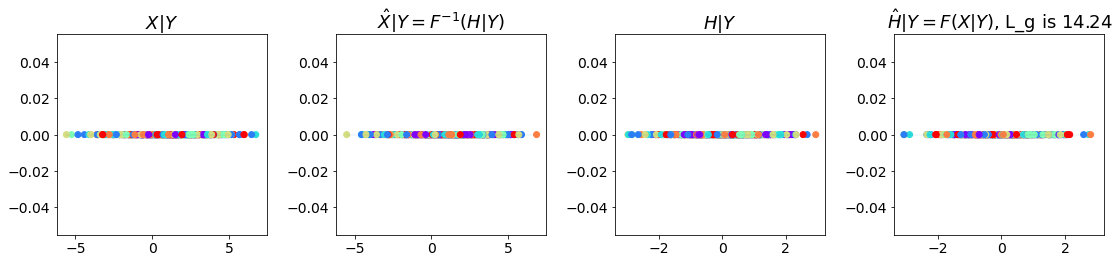

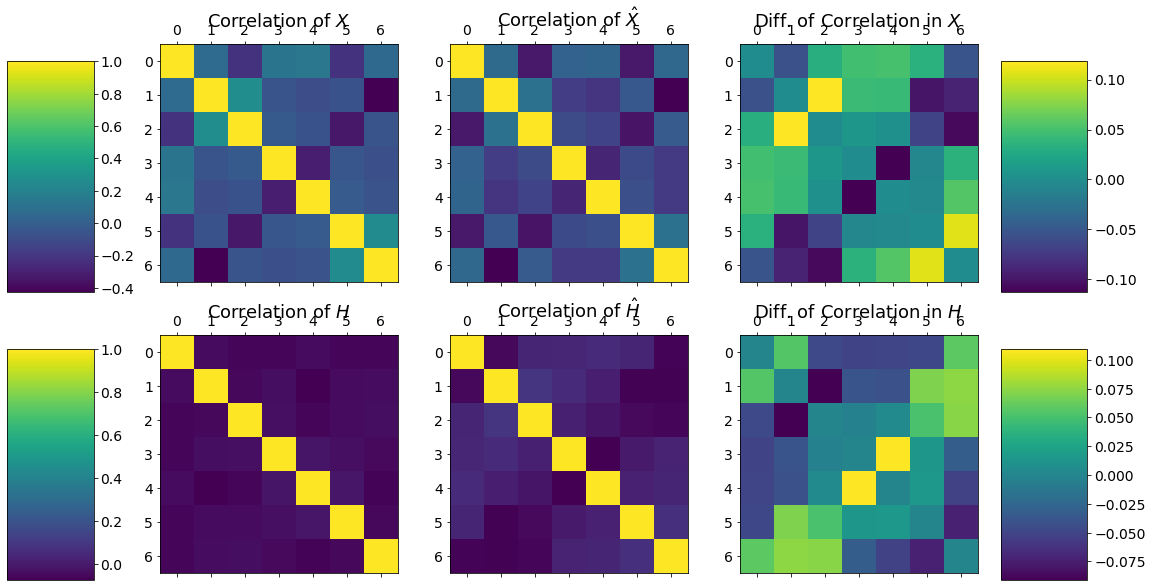

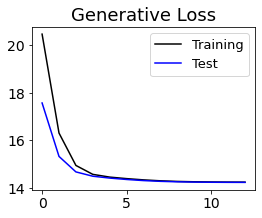

In [ ]:
# Directly load from saved checkpoint for visualization
train_args[-1] = True  # If resume_training
simulation_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test=None, Y_test=None)
simulation_trainer.cpu_load = True
simulation_trainer.load_from_checkpoint()  # Load previous models from file
simulation_trainer.get_H_cond_Y()  # Get H|Y
simulation_trainer.viz = True  # If report transport cost
simulation_trainer.final_viz = True
simulation_trainer.viz_generation()
simulation_trainer.viz_losses()
data_generator.fig.savefig(
    f'{simulation_trainer.path}/rand_graph.png', dpi=200, bbox_inches='tight', pad_inches=0)

## C.2 $\Sigma$ and $\Sigma^{-1}$ are both local, but cannot be expressed by any spectral filter based on symmetry

In [ ]:
for _ in ['hyper-parameters']:
    # Define hyper-parameters
    # NOTE: V max is 10
    batch_size, epochs, F_out = 2000, 100, 1
    output_dim, Y_dim, nblocks = 1, 2, 40
    # it is 0.01 b/c we flow in R^1 continuously and scale too large cause non-invertibility. It is 1 because we just flow continuous in R
    model_args = [0.01, 1, 3]

[[ 1.75       -1.25       -0.5       ]
 [-1.25        2.08333333  0.83333333]
 [-0.5         0.83333333  1.33333333]]


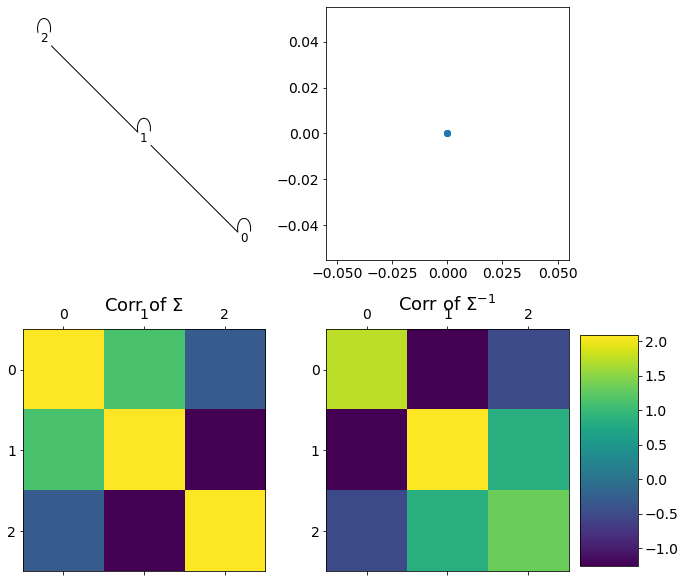

In [ ]:
num_sample, V = 4000, 3
data_generator = utils_data.GP_graph(num_sample, V)
Sigma_type = 'Local'  # 'ChebNet' or 'Local'
data_generator.gen_1d_GP_data(Sigma_type=Sigma_type)

In [ ]:
data_generator.Sigma

tensor([[ 1.0000,  0.6000,  0.0000],
        [ 0.6000,  1.0000, -0.4000],
        [ 0.0000, -0.4000,  1.0000]], device='cuda:0')

### iGNN-L3 (enough expressiveness)

In [ ]:
# Data
num_sample = 4000
Sigma_type = 'Local'  # 'ChebNet' or 'Local'
V = 7 if Sigma_type == 'ChebNet' else 3
data_generator = utils_data.GP_graph(num_sample, V)
data_generator.gen_1d_GP_data(Sigma_type=Sigma_type)
# Below for training, was a part of the whole things
X_train, Y_train = data_generator.X_train, data_generator.Y_train
X_test, Y_test = data_generator.X_test, data_generator.Y_test
# Model
C = 1
edge_index = None
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'simulation_GP_graph', 'one_L3', edge_index, X_train, Y_train, X_test, Y_test)
train_args[-1] = False  # If resume_training
data_args[3] = 'GP_graph_one_L3_local'
data_args[-2] = 1  # Only visualize Y that are used
if 'one_Cheb' in data_args[-3]:
    # Include edge weight for Cheb
    data_args[1] = data_generator.edge_weights
simulation_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
# simulation_trainer.all_together()

Checking generation at 
 tensor([0., 0., 0.], device='cuda:0') with 4000 out of 4000 data
Invert 100 samples took 0.27108257100007904 secs


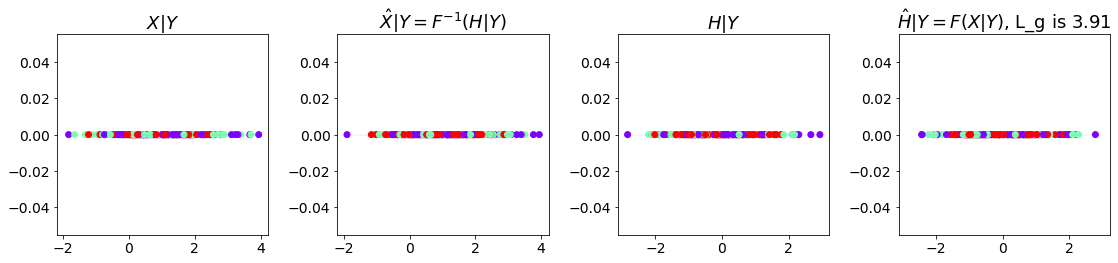

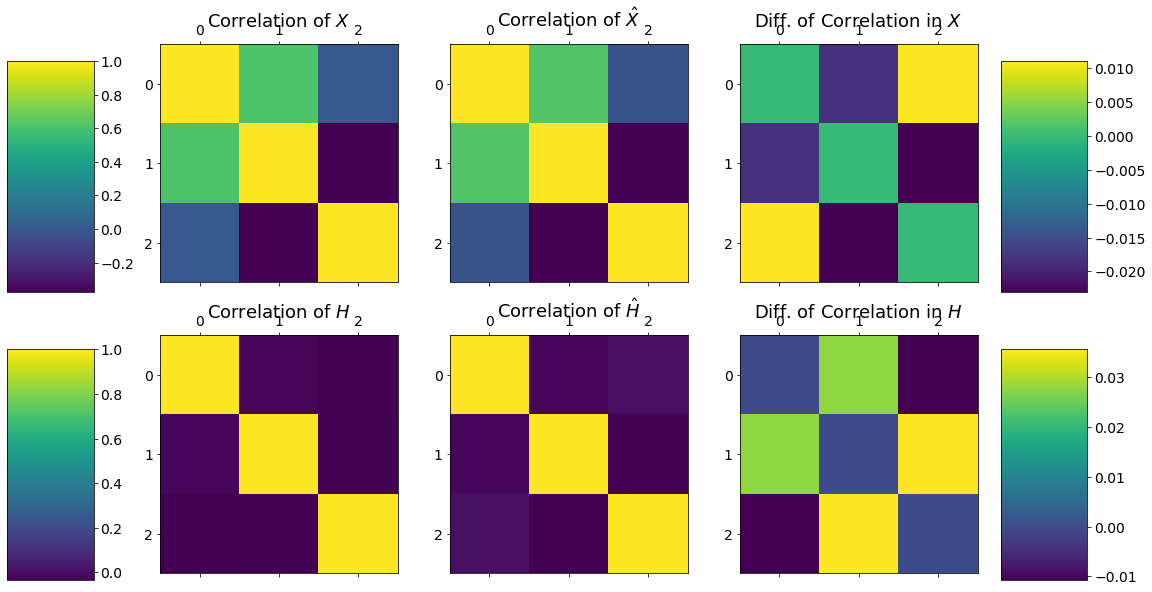

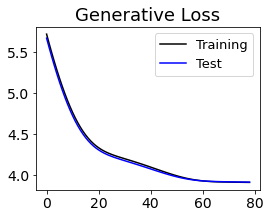

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()
    data_generator.fig.savefig(
        f'{simulation_trainer.path}/rand_graph.png', dpi=200, bbox_inches='tight', pad_inches=0)

### iGNN-Cheb (insufficient expressiveness)

In [ ]:
# Data
num_sample = 4000
Sigma_type = 'Local'  # 'ChebNet' or 'Local'
V = 7 if Sigma_type == 'ChebNet' else 3
data_generator = utils_data.GP_graph(num_sample, V)
data_generator.gen_1d_GP_data(Sigma_type=Sigma_type)
# Below for training, was a part of the whole things
X_train, Y_train = data_generator.X_train, data_generator.Y_train
X_test, Y_test = data_generator.X_test, data_generator.Y_test
# Model
C = 1
edge_index = data_generator.edge_index
models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test = get_training_input(
    'simulation_GP_graph', 'one_Cheb', edge_index, X_train, Y_train, X_test, Y_test)
train_args[-1] = False  # If resume_training
data_args[3] = 'GP_graph_one_Cheb_local'
data_args[-2] = 1  # Only visualize Y that are used
if 'one_Cheb' in data_args[-3]:
    # Include edge weight for Cheb
    data_args[1] = data_generator.edge_weights
simulation_trainer = utils.IResNet_training_on_graph(
    models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
simulation_trainer.all_together()

Checking generation at 
 tensor([0., 0., 0.], device='cuda:0') with 4000 out of 4000 data
Invert 100 samples took 1.3214198379992013 secs


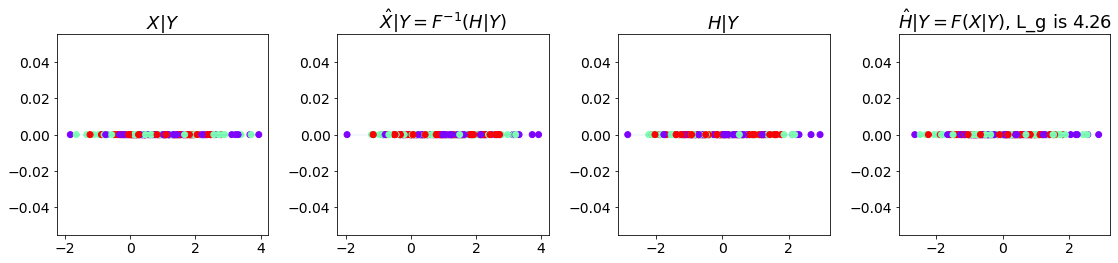

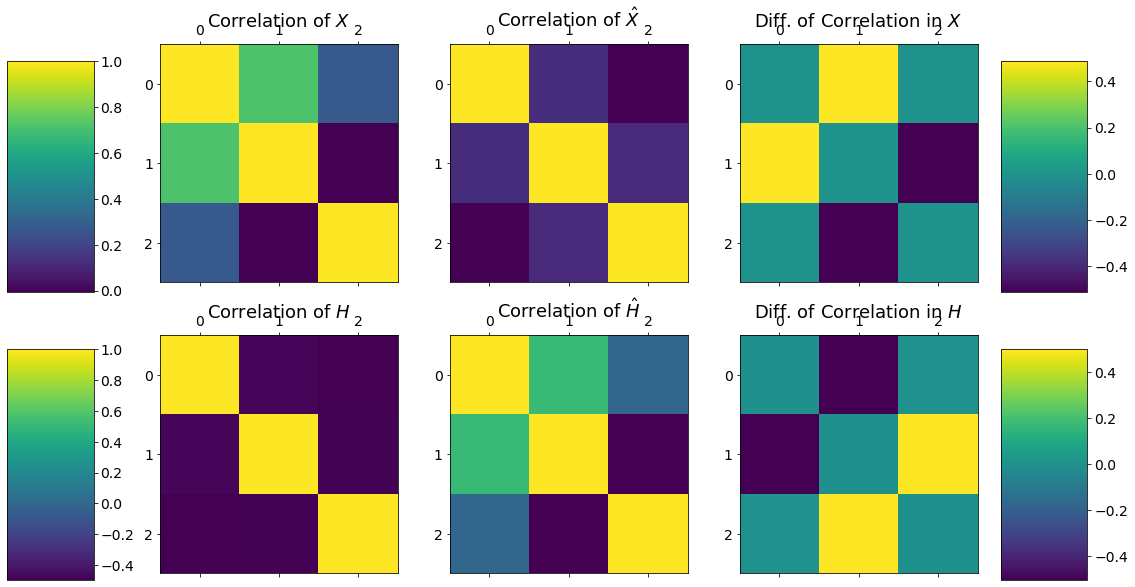

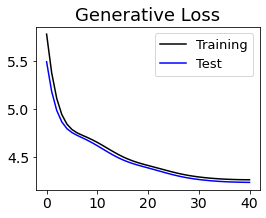

In [ ]:
for _ in ['Load_and_visualize']:
    # Directly load from saved checkpoint for visualization
    train_args[-1] = True  # If resume_training
    simulation_trainer = utils.IResNet_training_on_graph(
        models, mod_args, train_args, data_args, X_train, Y_train, X_test, Y_test)
    simulation_trainer.cpu_load = True
    simulation_trainer.load_from_checkpoint()  # Load previous models from file
    simulation_trainer.get_H_cond_Y()  # Get H|Y
    simulation_trainer.viz = True  # If report transport cost
    simulation_trainer.final_viz = True
    simulation_trainer.viz_generation()
    simulation_trainer.viz_losses()
    data_generator.fig.savefig(
        f'{simulation_trainer.path}/rand_graph.png', dpi=200, bbox_inches='tight', pad_inches=0)